In [19]:
import matplotlib.pyplot as plt
import numpy as np
import os, scipy

if os.getcwd().split(os.sep)[-1] == "examples":
    os.chdir('..')
    os.chdir('..')
    os.chdir('..')

# We import the model, stimuli, and the optimal control package
from neurolib.models.wc import WCModel
from neurolib.utils.stimulus import ZeroInput
from neurolib.optimal_control import oc_wc, cost_functions
from neurolib.optimal_control.oc_utils.plot_oc import plot_oc_network, plot_oc_nw

# This will reload all imports as soon as the code changes
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
comp_points = [[1., 0.5], [2.8, 1.6], [3., 0.5], [2., 0.5]]

### make 1 oscillate

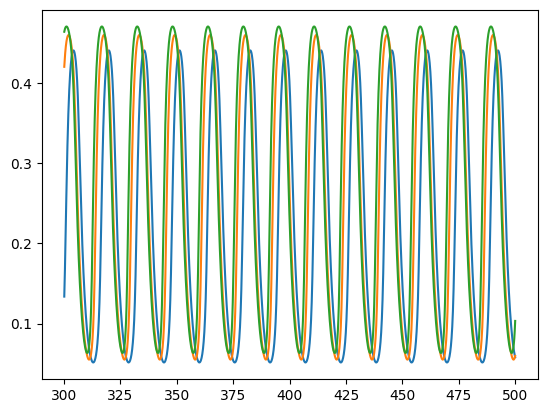

target oscillation period =  25.0
500


In [103]:
cmat = np.array( [[0., 0., 0.], [1., 0., 0.], [1., 1., 0.]] ) # diagonal elements are zero, connection strength is 1 from node 0 to node 1
dmat = np.array( [[0., 0., 0.], [10., 0., 0.], [10., 10., 0.]] ) # delay from 0 to 1

N = cmat.shape[0]

controlmat = np.zeros((N, N))
controlmat[:,0] = 1.

costmat = np.array( [[0., 0.], [1., 0.], [0., 0.]] )

model = WCModel(Cmat=cmat, Dmat=dmat)

dt = 0.1
model.params['dt'] = dt # Integration time step, ms
model.params['duration'] = 1. * 1000 # Simulation time, ms
model.params["exc_ext"] = 2.
model.params["inh_ext"] = 0.5
model.params.signalV = 1.

model.run()

peaks = scipy.signal.find_peaks(model.exc[0,100:])[0]
plist = []
for pind in range(1, len(peaks)):
    plist.append(model.params.dt * (peaks[pind]-peaks[pind-1]))

period = np.around(np.mean(plist),2)

plt.plot(model.t[3000:5000], model.exc[0,3000:5000])
plt.plot(model.t[3000:5000], model.exc[1,3000:5000])
plt.plot(model.t[3000:5000], model.exc[2,3000:5000])
plt.show()

duration = 200.
model.params.duration = duration
zero_input0 = ZeroInput().generate_input(duration=duration+model.params.dt, dt=model.params.dt)
zero_input = np.vstack( (zero_input0, zero_input0, zero_input0))
zero_control0 = np.concatenate( (zero_input, zero_input, zero_input), axis=0)[np.newaxis,:,:]
zero_control = np.vstack( (zero_control0, zero_control0, zero_control0))

w1_array = [1e-4]

target_period = 25.
print("target oscillation period = ", target_period)
int0 = int( (duration - 6. * target_period) / model.params.dt)
print(int0)

In [88]:
results = dict()
results["controls"] =  [ [ None], [ None], [ None], [ None] ]

In [89]:
savepath = ".." + os.sep + "Talks_Conf_Workshops_Schools" + os.sep + "23" + os.sep + "03Goettingen" + os.sep + "poster" + os.sep + "images"

max delay =  100
Optimal control with target oscillation period
L2 cost weight =  0.0001
Compute control for a deterministic system
Cost in iteration 0: -0.2605583088890191
Converged in iteration 12 with cost -0.26718009834099626
Final cost : -0.26718009834099626


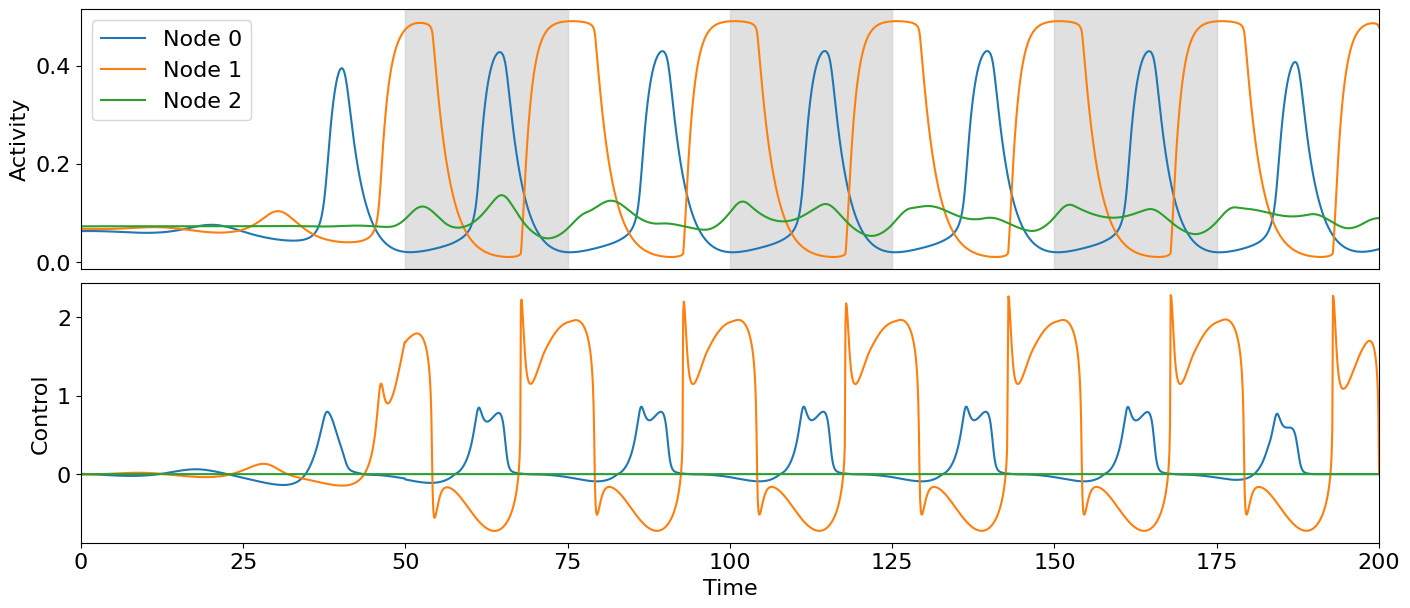

max delay =  100
Optimal control with target oscillation period
L2 cost weight =  0.0001
Compute control for a deterministic system
Cost in iteration 0: -0.27100370811150976
Cost in iteration 50: -0.2710208883118578
Cost in iteration 100: -0.2710302940180732
Cost in iteration 150: -0.2710361179056115
Cost in iteration 200: -0.2710408084434852
Cost in iteration 250: -0.27104524566331545
Cost in iteration 300: -0.2710499646487916
Cost in iteration 350: -0.27105322320002007
Cost in iteration 400: -0.271055364926852
Cost in iteration 450: -0.27105712897912004
Cost in iteration 500: -0.27105809952239224
Cost in iteration 550: -0.2710587863106351
Cost in iteration 600: -0.27105925135575043
Cost in iteration 650: -0.27105955780034885
Cost in iteration 700: -0.2710598326119222
Cost in iteration 750: -0.27105995264345206
Cost in iteration 800: -0.2710600657698306
Converged in iteration 818 with cost -0.27106008537807647
Final cost : -0.27106008537807647


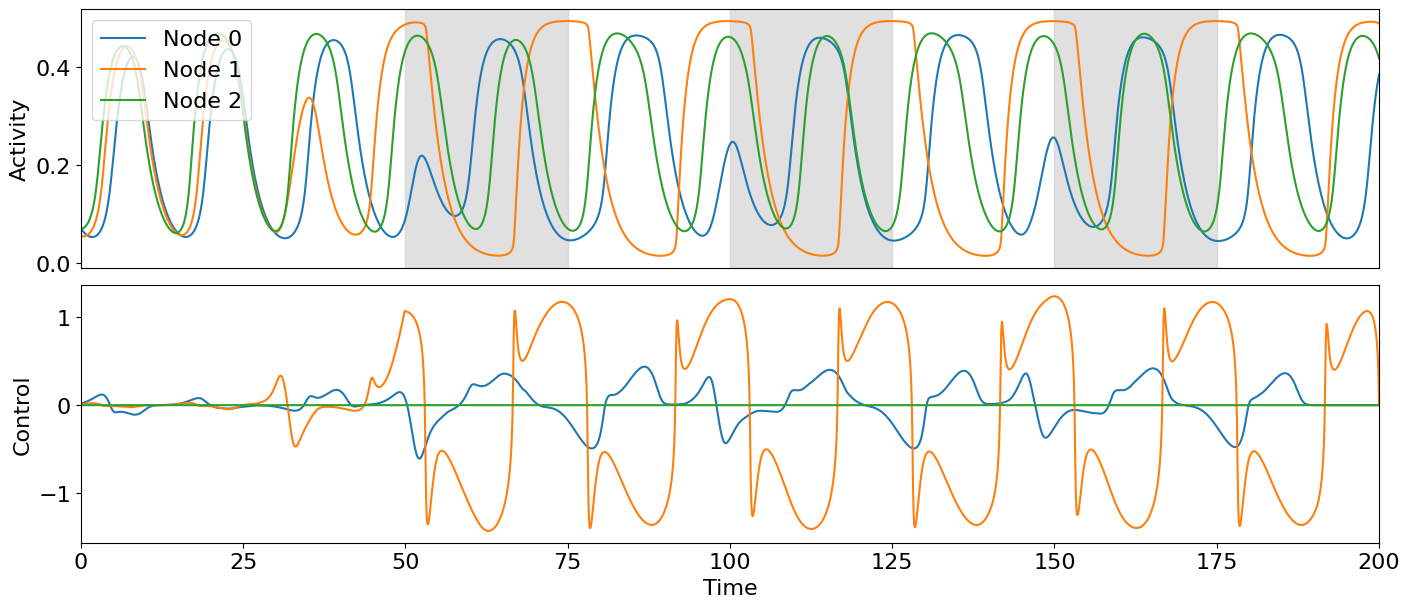

In [104]:
it = 1000
pr = np.arange(0,1001,50)
maxstr = 5.

for pind in [0, 3]:
    p = comp_points[pind]
    model.params["exc_ext"] = zero_input + p[0]
    model.params["inh_ext"] = zero_input + p[1]
    testd = 1000.
    model.params.duration = testd
    model.run()

    e0 = model.exc[0,-1]
    e1 = model.exc[1,-1]
    e2 = model.exc[2,-1]
    i0 = model.inh[0,-1]
    i1 = model.inh[1,-1]
    i2 = model.inh[2,-1]

    nmaxdel = model.getMaxDelay()
    print("max delay = ", nmaxdel)
    e0stack = [e0] * (nmaxdel+1)
    e1stack = [e1] * (nmaxdel+1)
    e2stack = [e2] * (nmaxdel+1)
    i0stack = [i0] * (nmaxdel+1)
    i1stack = [i1] * (nmaxdel+1)
    i2stack = [i2] * (nmaxdel+1)

    model.params.duration = duration

    model.params["exc_init"] = np.array([e0stack, e1stack, e2stack])
    model.params["inh_init"] = np.array([i0stack, i1stack, i2stack])

    for iw in range(len(w1_array)):
        w1 = w1_array[iw]

        if iw not in [0]:
            continue

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix = controlmat)
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f"] = 1.
        model_controlled.weights["w_2"] = w1
        print("L2 cost weight = ", w1)

        if type(results["controls"][pind][iw]) != type(None):
            model_controlled.control = results["controls"][pind][iw]
            if pind == 0:
                model_controlled.control[:,0,:500] = 0.
            #model_controlled.control[0,0,:] = 0.
            #model_controlled.control[2,0,:] = 0.
            model_controlled.update_input()

        model_controlled.optimize(it)
        results["controls"][pind][iw] = model_controlled.control.copy()

        plot_oc_nw(N, duration, dt, model_controlled.get_xs(), target_period,  model_controlled.control, filename=os.path.join(savepath, str(pind) + "_i.pdf"))

### synchronize

In [105]:
costmat = np.array( [[1., 0.], [1., 0.], [1., 0.]] )

model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.signalV = 1.

duration = 200.
model.params.duration = duration

In [72]:
results_syn = dict()
results_syn["controls"] =  [ [ None], [ None], [ None], [ None] ]

max delay =  100
Optimal control with target oscillation period
L1 cost weight =  0.0001
Compute control for a deterministic system
Cost in iteration 0: -0.7770609335401653
Converged in iteration 25 with cost -0.7965909131500373
Final cost : -0.7965909131500373


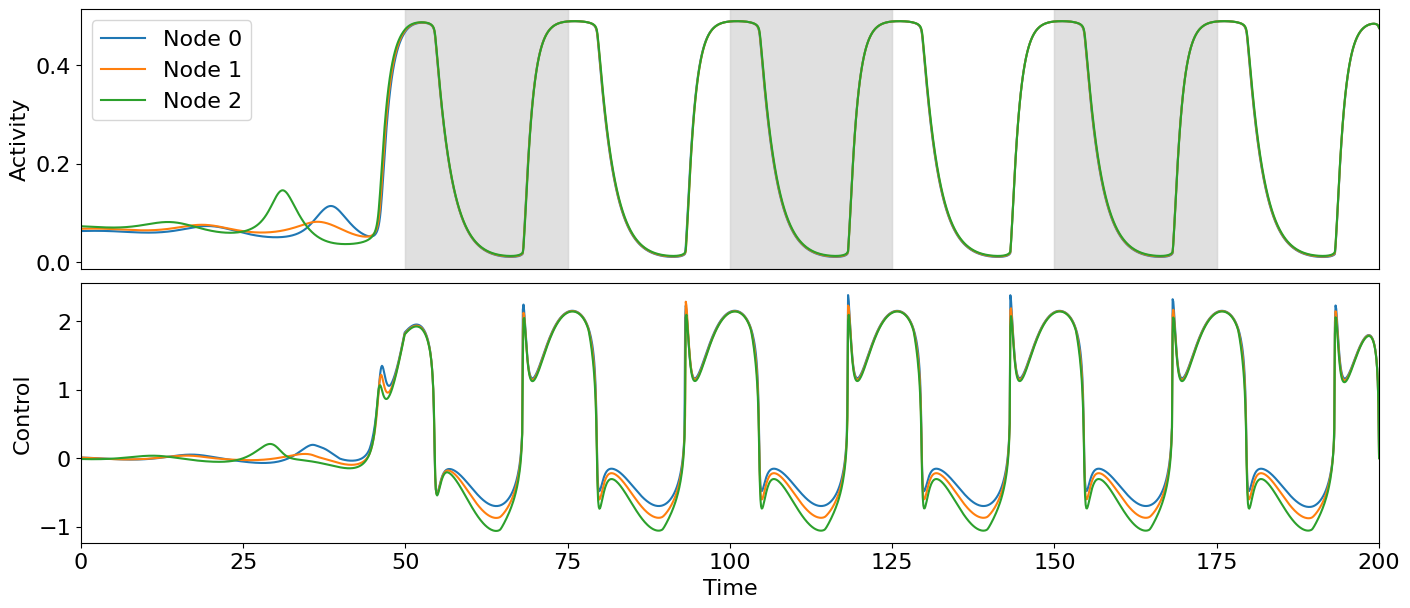

max delay =  100
Optimal control with target oscillation period
L1 cost weight =  0.0001
Compute control for a deterministic system
Cost in iteration 0: -0.8056002489808493
Converged in iteration 23 with cost -0.8056002862049678
Final cost : -0.8056002862049678


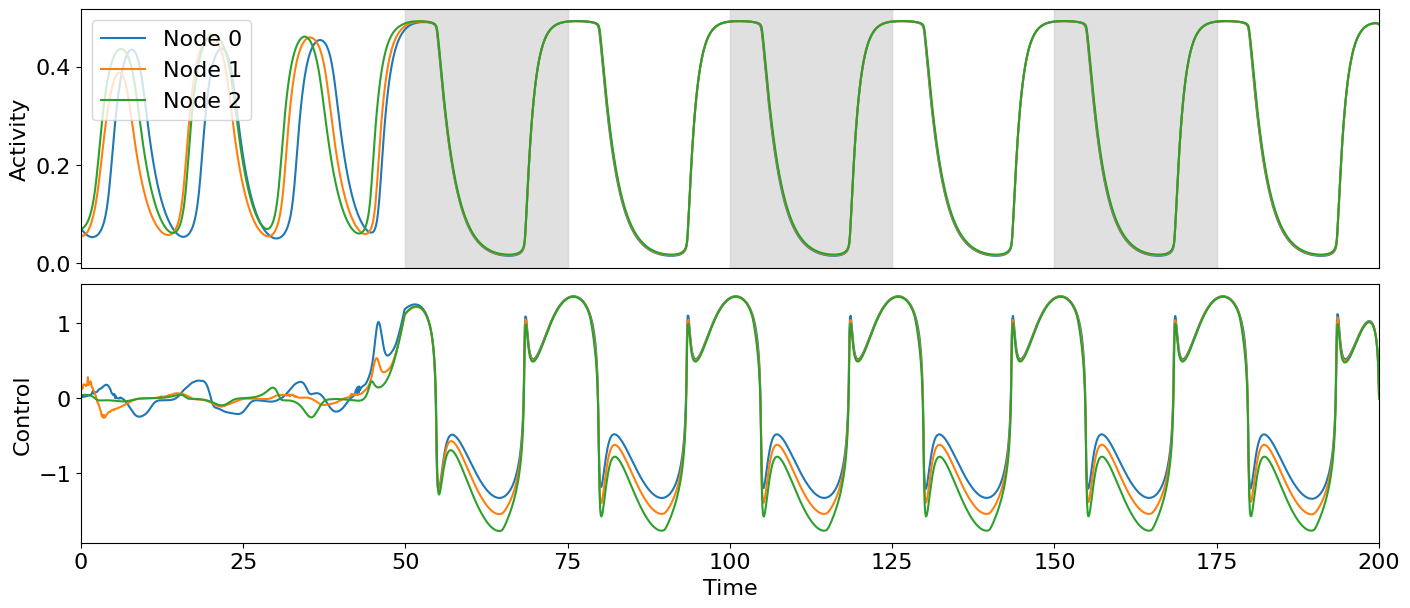

In [106]:
it = 1000
pr = np.arange(0,1001,50)
maxstr = 5.

for pind in [0, 3]:
    p = comp_points[pind]
    model.params["exc_ext"] = zero_input + p[0]
    model.params["inh_ext"] = zero_input + p[1]
    testd = 1000.
    model.params.duration = testd
    model.run()

    e0 = model.exc[0,-1]
    e1 = model.exc[1,-1]
    e2 = model.exc[2,-1]
    i0 = model.inh[0,-1]
    i1 = model.inh[1,-1]
    i2 = model.inh[2,-1]

    nmaxdel = model.getMaxDelay()
    print("max delay = ", nmaxdel)
    e0stack = [e0] * (nmaxdel+1)
    e1stack = [e1] * (nmaxdel+1)
    e2stack = [e2] * (nmaxdel+1)
    i0stack = [i0] * (nmaxdel+1)
    i1stack = [i1] * (nmaxdel+1)
    i2stack = [i2] * (nmaxdel+1)

    model.params.duration = duration

    model.params["exc_init"] = np.array([e0stack, e1stack, e2stack])
    model.params["inh_init"] = np.array([i0stack, i1stack, i2stack])

    for iw in range(len(w1_array)):
        w1 = w1_array[iw]

        if iw not in [0]:
            continue

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix = controlmat)
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f_sync"] = 1.
        model_controlled.weights["w_2"] = w1
        print("L1 cost weight = ", w1)

        if type(results_syn["controls"][pind][iw]) != type(None):
            model_controlled.control = results_syn["controls"][pind][iw]
            if pind == 0:
                model_controlled.control[:,0,:500] = 0.
            model_controlled.update_input()

        model_controlled.optimize(it)
        results_syn["controls"][pind][iw] = model_controlled.control.copy()

        plot_oc_nw(N, duration, dt, model_controlled.get_xs(), target_period,  model_controlled.control, filename=os.path.join(savepath, str(pind) + "_ii.pdf"))

### phase-lock

In [75]:
model = WCModel(Cmat=cmat, Dmat=dmat)
model.params.signalV = 1.

duration = 200.
model.params.duration = duration

In [76]:
results_pl = dict()
results_pl["controls"] =  [ [ None], [ None], [ None], [ None] ]

max delay =  100
Optimal control with target oscillation period
L1 cost weight =  0.0001
Compute control for a deterministic system
Cost in iteration 0: -0.7773370344001055
Cost in iteration 50: -0.7969313413617595
Cost in iteration 100: -0.7975588442712234
Cost in iteration 150: -0.7983078573470257
Cost in iteration 200: -0.7991206628431046
Cost in iteration 250: -0.8002949095978283
Cost in iteration 300: -0.801887523954925
Cost in iteration 350: -0.8024709297747735
Cost in iteration 400: -0.8027594712377522
Cost in iteration 450: -0.8031259654535261
Cost in iteration 500: -0.8034886401879925
Cost in iteration 550: -0.8037437616689936
Cost in iteration 600: -0.8040415313963512
Cost in iteration 650: -0.8072784944270966
Cost in iteration 700: -0.807600409604841
Converged in iteration 743 with cost -0.8076089191331556
Final cost : -0.8076089191331556


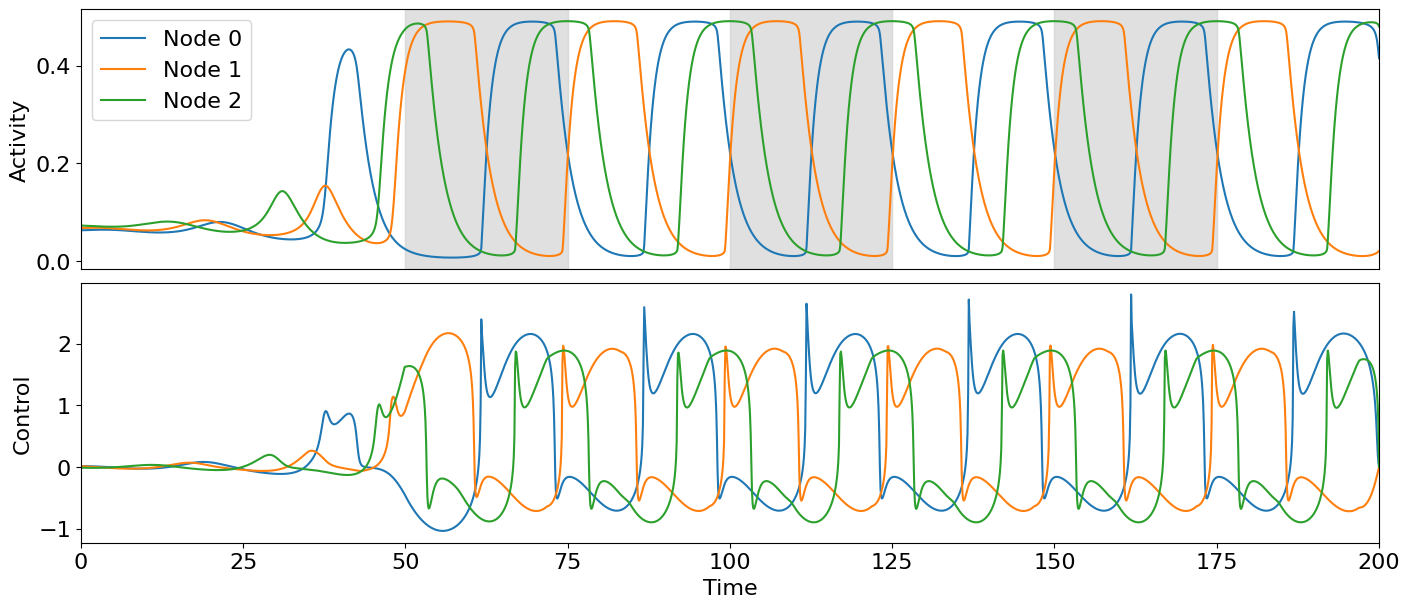

max delay =  100
Optimal control with target oscillation period
L1 cost weight =  0.0001
Compute control for a deterministic system
Cost in iteration 0: -0.8100409747598942
Cost in iteration 50: -0.8103022184205568
Converged in iteration 62 with cost -0.810304555206147
Final cost : -0.810304555206147


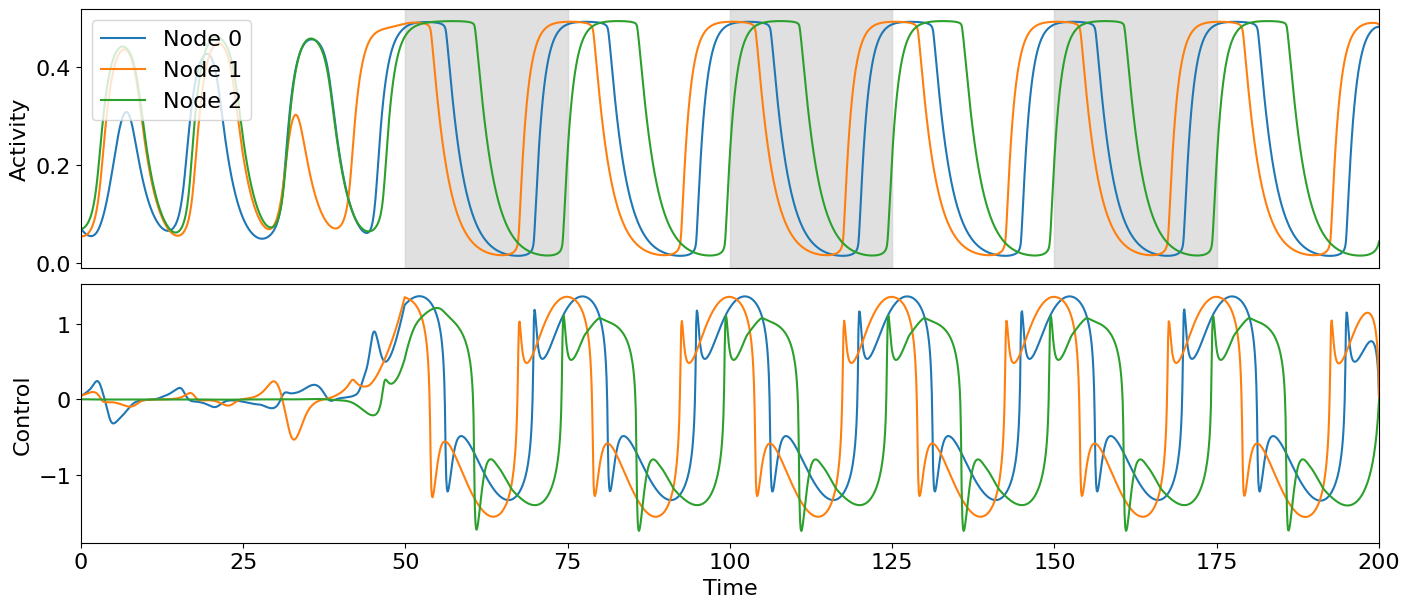

In [107]:
it = 1000
pr = np.arange(0,1001,50)
maxstr = 5.

for pind in [0, 3]:
    p = comp_points[pind]
    model.params["exc_ext"] = zero_input + p[0]
    model.params["inh_ext"] = zero_input + p[1]
    testd = 1000.
    model.params.duration = testd
    model.run()

    e0 = model.exc[0,-1]
    e1 = model.exc[1,-1]
    e2 = model.exc[2,-1]
    i0 = model.inh[0,-1]
    i1 = model.inh[1,-1]
    i2 = model.inh[2,-1]

    nmaxdel = model.getMaxDelay()
    print("max delay = ", nmaxdel)
    e0stack = [e0] * (nmaxdel+1)
    e1stack = [e1] * (nmaxdel+1)
    e2stack = [e2] * (nmaxdel+1)
    i0stack = [i0] * (nmaxdel+1)
    i1stack = [i1] * (nmaxdel+1)
    i2stack = [i2] * (nmaxdel+1)

    model.params.duration = duration

    model.params["exc_init"] = np.array([e0stack, e1stack, e2stack])
    model.params["inh_init"] = np.array([i0stack, i1stack, i2stack])

    for iw in range(len(w1_array)):
        w1 = w1_array[iw]

        if iw not in [0]:
            continue

        model_controlled = oc_wc.OcWc(model, target_period, print_array=pr, cost_interval=(int0,None), cost_matrix=costmat, control_matrix = controlmat)
        model_controlled.maximum_control_strength = maxstr
        model_controlled.weights["w_p"] = 0.
        model_controlled.weights["w_f_pl"] = 1.
        model_controlled.weights["w_2"] = w1
        print("L1 cost weight = ", w1)

        if type(results_pl["controls"][pind][iw]) != type(None):
            model_controlled.control = results_pl["controls"][pind][iw]
            if pind == 0:
                model_controlled.control[:,0,:500] = 0.
            model_controlled.update_input()

        model_controlled.optimize(it)
        results_pl["controls"][pind][iw] = model_controlled.control.copy()

        plot_oc_nw(N, duration, dt, model_controlled.get_xs(), target_period,  model_controlled.control, filename=os.path.join(savepath, str(pind) + "_iii.pdf"))